In [1]:
import numpy as np
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
from sklearn import linear_model
plt.rcParams["figure.figsize"] = (16,8)
import math
from math import sqrt
from math import e as exp
import seaborn as sns
import statsmodels.api as sm
import random
from scipy import optimize
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
from IPython.core.display import display, HTML
from pymc3.distributions import Continuous, Normal
from theano.tensor.random.basic import RandomVariable, normal
from ipywidgets import interact, interact_manual, interactive,interactive_output, Layout
import ipywidgets as widgets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

In [2]:
def _solved_river_abv(x):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*sqrt(V**2 + 4*D * λ)+ V**2)* exp**( (V - sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _solved_river_bl(x):
    return  (pf/(BV*H)) *(2*B*u*D) /(4*D*λ + V*sqrt(V**2 + 4*D * λ)+ V**2) * exp**( (V + sqrt(V**2 + 4*D*λ))/ (2*D) * x )


def _solved_river_abv_complete(x, pf, BV, H, B, u, D, λ, V):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*np.sqrt(V**2 + 4*D * λ)+ V**2)* np.exp( (V - np.sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _solved_river_abv_complete_tt(x, pf, BV, H, B, u, D, λ, V):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*tt.sqrt(V**2 + 4*D * λ)+ V**2)* tt.exp( (V - tt.sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _sld_intermediary(Xi, Xf):
    low, high = sorted([Xi, Xf])
    if low >= 0:
        return abs(_solved_river_abv(Xf) - _solved_river_abv(Xi))
    if high <= 0: 
        return abs(_solved_river_bl(Xf) - _solved_river_bl(Xi))

    return _sld_intermediary(low, 0) + _sld_intermediary(0, high)

def sample_eDNA_transect(x0):
    ret = _sld_intermediary(x0, x0 + BV*T)
    if ret< 0: return 0
    else: return ret
    
def sample_eDNA_transect_dowstream_only(x0, T,  pf, BV, H, B, u, D, λ, V):
    return _solved_river_abv_complete(x0+BV*T, pf, BV, H, B, u, D, λ, V) - _solved_river_abv_complete(x0, pf, BV, H, B, u, D, λ, V)

def sample_eDNA_transect_dowstream_only_tt(x0, T,  pf, BV, H, B, u, D, λ, V):
    return _solved_river_abv_complete_tt(x0+BV*T, pf, BV, H, B, u, D, λ, V) - _solved_river_abv_complete_tt(x0, pf, BV, H, B, u, D, λ, V)

class ZeroInflatedNormalRV(RandomVariable):
    name = "zero_inflated_normal"
    ndim_supp = 0
    ndims_params = [0, 0, 0]
    dtype = "int64"
    _print_name = ("ZeroInflatedNormal", "\\operatorname{ZeroInflatedNormal}")

    @classmethod
    def rng_fn(cls, rng, pi,mu ,sigma,  size):
        return rng.normal(mu=mu, sigma=sigma, size=size) * (rng.random(size=size) < pi)
    
    
class ZeroInflatedNormal(Continuous):
    rv_op = ZeroInflatedNormalRV
    
    def __init__(self, mu, sigma, pi, *args, **kwargs):
        super(ZeroInflatedNormal, self).__init__(*args, **kwargs)
        self.mu = mu
        self.sigma = sigma
        self.pi = pi = tt.as_tensor_variable(pi)
        self.Normal = pm.Normal.dist(mu, sigma)

    def logp(self, value):
        return tt.switch(value > 0,
                         tt.log(1 - self.pi) + self.Normal.logp(value),
                         tt.log(self.pi))
        
def log_clip(X):
    return tt.log(tt.clip(X, 1e-10, 1e10))

def log_clipnp(X):
    return np.log(np.clip(X, 1e-10, 1e10))

In [3]:
wood = pd.read_csv('wood et all.csv')
wood = wood[(wood['Dist (m)'] != 'Upstream') & (wood['Position'] == 'MidStream')]
wood = wood.dropna(subset=['Dist (m)', 'FishMass (g)','Velocity (m/s)', 'Detect', 'Pg eDNA'])
wood['Dist (m)']= wood['Dist (m)'].astype(float) 
wood['FishMass (kg)'] = wood['FishMass (g)'].astype(float)/1000
wood['Velocity (m/s)']= wood['Velocity (m/s)'].astype(float)
wood = wood[(wood['Dist (m)'] <3000) &  (wood['Dist (m)'] > 0) &  (wood['Velocity (m/s)']>0)]

df= wood.copy()

In [4]:
df

,River,Month,Temp (C),Fish,FishMass (g),Dist (m),Position,Velocity (m/s),Depth (m),Cq,Pg eDNA,Detect,FishMass (kg)
4,Dennis Stream,June,14.6,3,105.0,5.0,MidStream,0.27,0.36,38.88,4.15,1,0.105
7,Dennis Stream,June,14.6,3,105.0,50.0,MidStream,0.64,0.36,0.00,0.00,0,0.105
10,Dennis Stream,June,14.6,3,105.0,100.0,MidStream,0.58,0.23,0.00,0.00,0,0.105
13,Dennis Stream,June,14.6,3,105.0,200.0,MidStream,0.34,0.25,0.00,0.00,0,0.105
16,Dennis Stream,June,14.6,3,105.0,400.0,MidStream,0.34,0.53,0.00,0.00,0,0.105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,Digdeguash River,October,8.0,10,2117.0,100.0,MidStream,0.30,0.36,0.00,0.00,0,2.117
880,Digdeguash River,October,8.0,10,2117.0,200.0,MidStream,0.40,0.62,40.75,1.18,1,2.117
883,Digdeguash River,October,8.0,10,2117.0,400.0,MidStream,0.60,0.48,0.00,0.00,0,2.117
886,Digdeguash River,October,8.0,10,2117.0,800.0,MidStream,0.30,0.61,37.57,10.03,1,2.117


In [5]:
#@title #Estimate most likely values for eDNA production rate, diffusion and degradation using ADVI (it should take a few minutes to run)
layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='60%')
style = {'description_width': 'initial'}


@interact_manual(Biomass_Kg = widgets.Dropdown(options = df.columns, layout = layout, style = style ),
                 distances_Meters = widgets.Dropdown(options = df.columns, layout = layout, style = style),
                 Velocity_MetersPerSecond = widgets.Dropdown(options = df.columns, layout = layout, style = style),
                 distances = widgets.Dropdown(options = df.columns, layout = layout, style = style ),
                 observed_eDNA_copies_or_binary_detection = widgets.Dropdown(options = df.columns,layout = layout, style = style ),
                 eDNA_format = widgets.Dropdown(options = ['Positive or Negative', 'Concetration (pg/ul) or (copies/L)'], 
                                                value =  'Concetration (pg/ul) or (copies/L)' ,
                                               layout = layout, style = style),
                 use_zero_inflation = widgets.Dropdown(options = ['True', 'False'], value = 'True',layout = layout, style = style),
                 force_lambda = widgets.Text( value = 'add fixed lambda', layout = layout, style = style),
                 force_diffusion = widgets.Text( value = 'add fixed diffusion', layout = layout, style = style),
                 force_production = widgets.Text( value = 'add fixed production rate', layout = layout, style = style),
                 transect_length = widgets.BoundedFloatText(value  = 1e-5, min = 1e-5, max = 1000,layout = layout, style = style ),
                 total_volume = widgets.BoundedFloatText(value  = 1, min = 0.05, max = 10 ,layout = layout, style = style),
                 river_crossection_m2 = widgets.BoundedFloatText(value  = 10 , min = 1, max = 1000 ,layout = layout, style = style),
)
def Optimize(Biomass_Kg, distances_Meters, Velocity_MetersPerSecond,
             observed_eDNA_copies_or_binary_detection,eDNA_format, use_zero_inflation,
             force_lambda,force_diffusion,force_production, transect_length, total_volume, river_crossection_m2 ):
    
    global dic 
    dic = {}
    global params
    dist = df[[distances_Meters]].values
    mass = df[[Biomass_Kg]].values
    vel = df[[Velocity_MetersPerSecond]].values
    T = 200
    BV = transect_length/T
    pf = total_volume/T
    H = river_crossection_m2
    params = {'x0':dist, 'B': mass,'V':vel, 'T':T, 'BV':BV, 'pf':pf, 'H': H}
    if eDNA_format == 'Concetration (pg/ul) or (copies/L)':
        scaler = MinMaxScaler(feature_range=(0,1e5))
        observed = scaler.fit_transform(df[[observed_eDNA_copies_or_binary_detection]].values)
        copies_upper_bound = observed.max()*5
        dic['scaler'] = scaler
    else:
        observed = np.where(df[[observed_eDNA_copies_or_binary_detection]].values>0.05, 1, 0)
        
    dic['observed']= observed
  
    with pm.Model() as model:
        name_lis = []
        key_lis = []
        
        if force_lambda == 'add fixed lambda':
            λ = pm.Bound(pm.Normal, lower=7.3e-5, upper = 7.3e-1)('degradation', mu=7.3e-4,sigma = 10.)
            name_lis += ['degradation']
            key_lis += ['λ']
        else:
            λ = float(force_lambda)
            params['λ'] = λ

        if force_diffusion == 'add fixed diffusion':
            D = pm.Bound(pm.Normal, lower=1e-2, upper = 10)('diffusion',  mu=.1, sigma = 10. ) 
            name_lis += ['diffusion']
            key_lis += ['D']
        else:
            D = float(force_diffusion)
            params['D'] = D

        if force_production == 'add fixed production rate':
            u = pm.Bound(pm.Normal, lower=3e2, upper = 3e6)('eDNA production rate', mu= 3e4, sigma=10.0) 
            name_lis += ['eDNA production rate']
            key_lis += ['u']
        else:
            u = float(force_production)
            params['u'] = u

        if eDNA_format ==  'Concetration (pg/ul) or (copies/L)':
            sigma = pm.HalfNormal("sigma", sigma=1)
            Yhat = pm.Deterministic('eDNA transport model',sample_eDNA_transect_dowstream_only_tt(dist , T, pf, BV, H, mass, u, D, λ, vel))
            Yhat = tt.clip(Yhat, 1e-2, copies_upper_bound) #cut large values
            if use_zero_inflation == 'False':
              ### non zero inflated
              Y_obs = Normal("Y_obs", mu=Yhat, sigma=sigma,observed=observed)

            if use_zero_inflation == 'True':
              ### zero inflated
                b = pm.Bound(pm.Normal, lower=0, upper = 1)('logistic concentration', mu = .5, sigma=5.0)
                pi = pm.Deterministic('logistic regression', 1/(1+ tt.exp(-tt.clip(Yhat*b-5, -5, 30))))
                Y_obs = ZeroInflatedNormal("Y_obs", mu=Yhat, sigma=sigma,pi= pi, observed=observed)

        if eDNA_format == 'Positive or Negative':
            b = pm.Bound(pm.Normal, lower=0, upper = 1)('logistic concentration', mu = .5, sigma=5.0)
            q = pm.Deterministic("eDNA transport model", sample_eDNA_transect_dowstream_only_tt(dist , T, pf, BV, H, mass, u, D, λ, vel))
            s = pm.Deterministic('logistic regression', 1/(1+ tt.exp(-tt.clip(q*b-5, -20, 20)))) ## logistic fit

            # Likelihood (sampling distribution) of observations
            Y_obs = pm.Bernoulli("Y_obs", p = s,observed=observed)


        fitted = pm.fit(method="fullrank_advi",n=100000,   progressbar=False)
        trace = fitted.sample(5000 )# 
        display(pm.model_to_graphviz(model))
        az.plot_trace(trace,var_names= [ '~eDNA transport model', '~logistic regression'], show = True)
        #display(az.summary(trace, round_to=8,  var_names= name_lis))
        #sns.despine()
        dic['trace']= trace
        dic['model']= model
        for k,i in zip(key_lis, az.summary(trace, round_to=8,  var_names= name_lis)['mean']):
            if k == 'u': 
                try: params[k] =  scaler.inverse_transform(np.array(i).reshape(1, -1))
                except: params[k] = i
            else:
                params[k] = i

        print('\n\n\n\n\n The estimated mean parameter values are:\n')
        display(pd.DataFrame({k: [np.mean(v)] for k,v in zip(params.keys(), params.values()) }))
        print('\n\n\n')
        ##### plotting
        
        mean_params= {k: np.mean(v) for k,v in list(zip(params.keys(), params.values()))[1:] }

        ppc = pm.sample_posterior_predictive(dic['trace'], model =dic['model'], var_names=['Y_obs','eDNA transport model'], progressbar=False)

        try:
            df['Yhat'] = dic['scaler'].inverse_transform(ppc['Y_obs'].mean(axis= 0))
            df['transport_model'] = np.clip(dic['scaler'].inverse_transform(ppc['eDNA transport model'].mean(axis= 0)), 1e-1, 1e7)
            df['scaled copies eDNA'] = np.clip(dic['scaler'].inverse_transform(dic['observed']), 1e-1, 1e20)

            f, ax = plt.subplots(figsize=(12, 7))

            plt.semilogy( np.linspace(0,dist.max(),1000), np.clip(sample_eDNA_transect_dowstream_only( x0 =  np.linspace(0,dist.max(),1000), **mean_params), 1e-1, 1e10))
            sns.scatterplot(data =df, x = distances_Meters, y = 'transport_model', label = 'transport_model', s = 100)
            sns.scatterplot(data =df, x = distances_Meters, y = 'scaled copies eDNA', label = 'y')
            sns.despine()
            ax.set(xscale="log", yscale = "log")# , yscale = "log" 
            plt.show()

        except:
            df['Yhat'] = ppc['Y_obs'].mean(axis= 0)
            df['transport_model'] = ppc['eDNA transport model'].mean(axis= 0)
            df['scaled copies eDNA'] = dic['observed']

            if len (np.unique(dic['observed'].astype(int))) == 2:
                f, ax = plt.subplots(figsize=(12, 7))
                ax.set(xscale="log")# 

                sns.regplot(data =df, x = distances_Meters, y = 'Yhat', label = 'yhat',  y_jitter = .05,  marker = 'o', logistic = True)
                sns.regplot(data =df, x = distances_Meters, y = 'scaled copies eDNA', label = 'y', color = 'r', y_jitter = 0.03, fit_reg = False, )

                sns.despine()
                plt.legend(loc = 'best')
                plt.ylim([0,1])
                plt.show()
                ConfusionMatrixDisplay(confusion_matrix(dic['observed'].astype(int), df['Yhat'].astype(int))).plot()
                plt.show()
                
        try:
            sptmpd = az.summary(dic['trace'], round_to=5,  var_names= ['logistic concentration'])
            sptmpd

            if 'scaler' in dic.keys():
                def logisreg_concentration(X):
                    return 1/(1+np.exp(-(sptmpd.loc['logistic concentration', 'mean']*(dic['scaler'].transform(X.reshape(-1,1)).flatten()) -5) ))

                xrange = dic['scaler'].inverse_transform(dic['observed'])

            else:
                def logisreg_concentration(X):
                    return 1/(1+np.exp(-(sptmpd.loc['logistic concentration', 'mean']*X -5) ))

                if len (np.unique(dic['observed'].astype(int))) == 2:
                    xrange = df['transport_model']

            edna_conc = np.linspace(0, xrange.max(), 1000)
            p_amp = logisreg_concentration(edna_conc)

            sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
            plt.plot(edna_conc, p_amp)
            plt.ylabel('Probability of amplification')
            plt.xlabel('eDNA concentration')
            sns.despine()

            sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
            plt.scatter(xrange, logisreg_concentration(xrange))
            plt.ylabel('Probability of amplification')
            plt.xlabel('eDNA concentration')
            sns.despine()
            plt.show()
        except:
            pass

    return
  

interactive(children=(Dropdown(description='Biomass_Kg', layout=Layout(align_items='stretch', display='flex', …

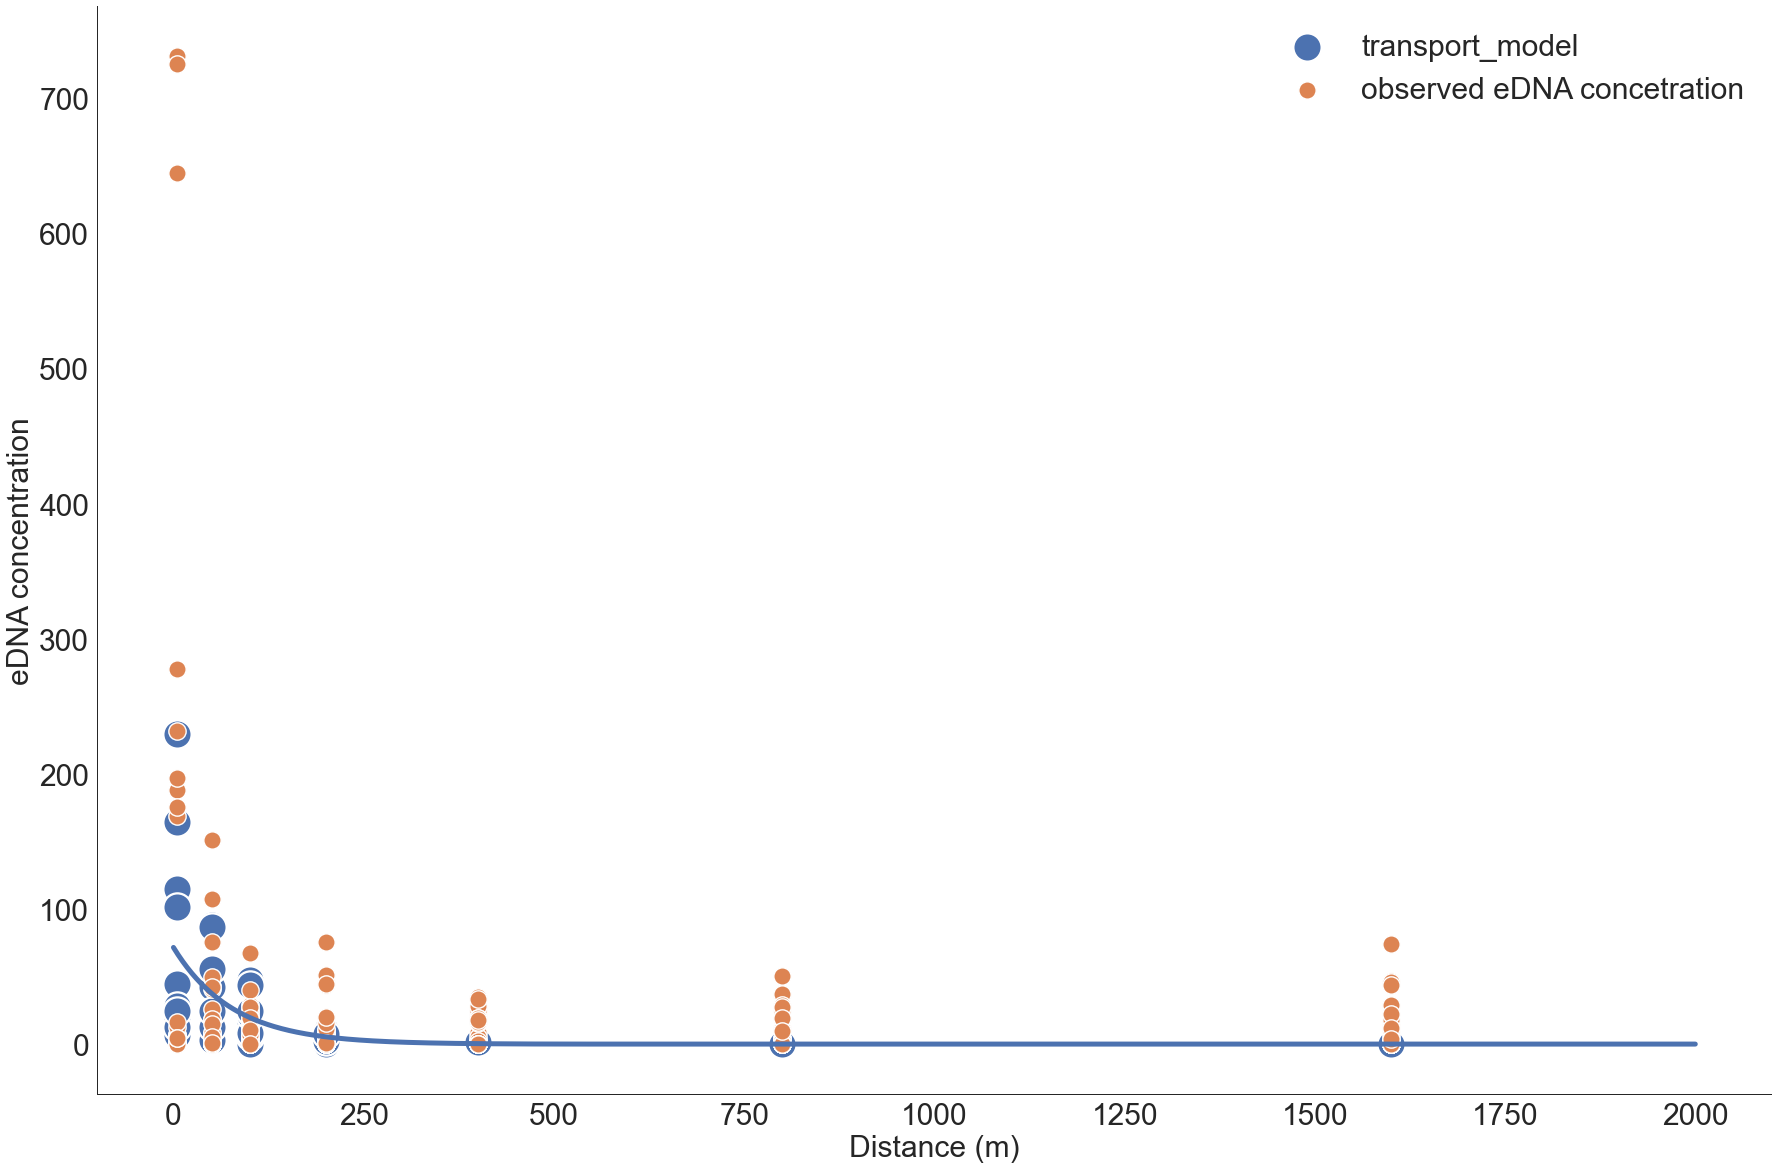

In [6]:
mean_params= {k: np.mean(v) for k,v in list(zip(params.keys(), params.values()))[1:]}
f, ax = plt.subplots(figsize=(30, 20))
plt.plot( np.linspace(0,2000,1000), np.clip(sample_eDNA_transect_dowstream_only( x0 =  np.linspace(0,2000,1000), **mean_params), 1e-1, 1e10), linewidth = 5)
sns.scatterplot(data =df, x = 'Dist (m)', y = 'transport_model', label = 'transport_model', s = 800)
sns.scatterplot(data =df, x = 'Dist (m)', y = 'scaled copies eDNA', label = 'observed eDNA concetration', s = 300)
sns.despine()
#ax.set( xscale = "log")# , yscale = "log"
plt.ylabel('eDNA concentration', fontsize=30 )
plt.xlabel('Distance (m)', fontsize=30 )
plt.legend(loc='best', fontsize=30 )
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.show()
